2D Manifold Visualizations
---

This notebook visualizes results generated by the script: scripts/lobpcg_modes_2d_opening_angle.py 
This notebook generates plots of the local minima / maxima and helps analysing the loss manifold.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pynoisy
import xarray as xr
import time, os, glob, re
from tqdm.notebook import tqdm

In [317]:
"""
Function definitions
"""
def grmhd_preprocessing(movie, initial_frame, eigenvector_coords, flux_threshold=1e-10):
    nt = eigenvector.coords['t'].size
    measurements = np.log(movie[initial_frame:initial_frame+nt].where(
        movie[initial_frame:initial_frame+nt] > flux_threshold))
    measurements = measurements - measurements.mean('t')
    measurements.coords.update(
        {'t': eigenvector.coords['t'], 'x': eigenvector.coords['x'], 'y': eigenvector.coords['y']})
    return measurements
    
def compute_residual(files, measurements, degree):
    residual = []
    for file in tqdm(files, leave=False):
        eigenvectors = xr.load_dataarray(file)
        residual.append(pynoisy.utils.projection_residual(measurements, eigenvectors, degree))
    residual = xr.concat(residual, dim='spatial_angle').sortby('spatial_angle')
    return residual

def compute_sliding_residual(files, movie, degree):
    residuals = []

    for file in tqdm(files, desc='files'):
        eigenvectors = xr.load_dataarray(file)
        frame_res = []
        for initial_frame in tqdm(range(len(movie)-nt+1), desc='sliding window', leave=False):
            measurements = grmhd_preprocessing(movie, inital_frame, eigenvectors.coords)
            residual = pynoisy.utils.projection_residual(measurements, eigenvectors, degree)
            residual = residual.expand_dims(initial_frame=[initial_frame])
            frame_res.append(residual)
        residuals.append(xr.concat(frame_res, dim='initial_frame'))
    residuals = xr.concat(residuals, dim='spatial_angle')
    return residuals

def visualization_2d(residuals, degree, ax, contours=False):
    dataset = residuals.sel(deg=degree)
    minimum = residuals[residuals.argmin(dim=['temporal_angle', 'spatial_angle'])].coords
    dataset.plot(ax=ax, add_labels=False)
    ax.scatter(minimum['temporal_angle'], minimum['spatial_angle'], s=40, c='r', marker='o', label='Global minima')
    if hasattr(residuals, 'true_temporal_angle'):
        ax.scatter(residuals.true_temporal_angle, residuals.true_spatial_angle, s=50, c='m', marker='x', label='True')
    if contours:
        cs = dataset.plot.contour(ax=ax, cmap='RdBu_r')
        ax.clabel(cs, inline=1, fontsize=10)
    ax.set_title('Residual Loss (degree={})'.format(degree),fontsize=16)
    ax.set_xlabel('Temporal angle [rad]', fontsize=12)
    ax.set_ylabel('Spatial angle [rad]', fontsize=12)
    ax.legend()
        
def generate_grf_from_residuals(residuals, nx=128, ny=128, nt=64, seed=None):
    estimated_angles = residuals[residuals.argmin(dim=['temporal_angle', 'spatial_angle'])]
    advection = pynoisy.advection.general_xy(nx, ny, opening_angle=float(estimated_angles['temporal_angle']))
    diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=float(estimated_angles['spatial_angle']))
    solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=seed)
    grf = solver.run(num_frames=nt, n_jobs=4, verbose=False)
    grf.attrs.update(
        spatial_angle=float(estimated_angles['spatial_angle']),
        temporal_angle=float(estimated_angles['temporal_angle'])
    )
    grf.name = None
    return grf

In [3]:
"""
Load precomputed modes (generated by the script: scripts/lobpcg_modes_2d_opening_angle.py)
"""
directory = '../../opening_angles_modes/'

files = [file for file in glob.glob(os.path.join(directory, '*.nc')) \
         if file.split('/')[-1].startswith('modes')]
eigenvector = xr.load_dataarray(files[0])
nt, nx, ny =  eigenvector.t.size, eigenvector.x.size, eigenvector.y.size

## "Inverse Crime": GRF Measurements
---
Computing measurements generated with the same forward model. This is an 'inverse crime' but is useful for basic analysis of the method

### Generate Measurements 

In [ ]:
true_spatial_angle = pynoisy.utils.uniform_sample(-np.pi/2, np.pi/2)
true_temporal_angle = pynoisy.utils.uniform_sample(-np.pi, np.pi)

advection = pynoisy.advection.general_xy(nx, ny, opening_angle=true_temporal_angle)
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=true_spatial_angle)

solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion)
measurements = solver.run(num_frames=nt, n_jobs=4, verbose=False)

<IPython.core.display.Javascript object>


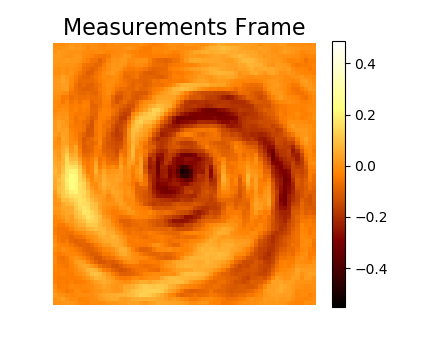

(-0.5, 0.484375, -0.5, 0.484375)

In [205]:
%matplotlib notebook
animation = measurements.noisy_methods.get_animation()
plt.title('Measurements Frame', fontsize=16)
plt.axis('off')

### Compute Residuals
---
Compute residuals using LOBPCG projection residual from precomputed modes and save as a NetCDF dataset

In [ ]:
degrees = [4, 8, 16, 24]
residuals = xr.concat([compute_residual(files, measurements, deg) for deg in degrees], dim='deg')

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    true_temporal_angle=solver.advection.opening_angle,
    true_spatial_angle=solver.diffusion.opening_angle,
    directory=directory, 
    measurement_seed=measurements.seed)

# Save output NetCDF
residuals.to_netcdf(
    os.path.join(directory, 'residuals.spatial_angle{:1.3}_temporal_angle{:1.3}_{}x{}.nc'.format(
        residuals.true_spatial_angle, residuals.true_temporal_angle, 
        residuals.spatial_angle.size, residuals.temporal_angle.size)))

### Load & Visualize Residuals
---

Load and visualize precomputed residuals

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


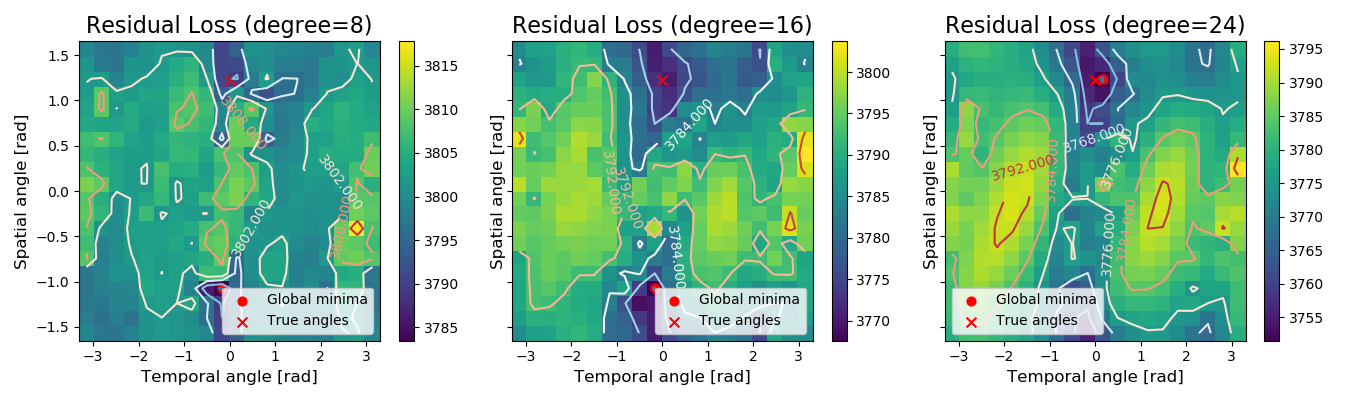

In [151]:
load_path = '../../opening_angles_modes/residuals.spatial_angle1.22_temporal_angle0.0_20x20.nc'
residuals = xr.load_dataarray(load_path)

%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4), sharey=True)
visualization_2d(residuals, degree=8, ax=ax[0])
visualization_2d(residuals, degree=16, ax=ax[1])
visualization_2d(residuals, degree=24, ax=ax[2])
plt.tight_layout()

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


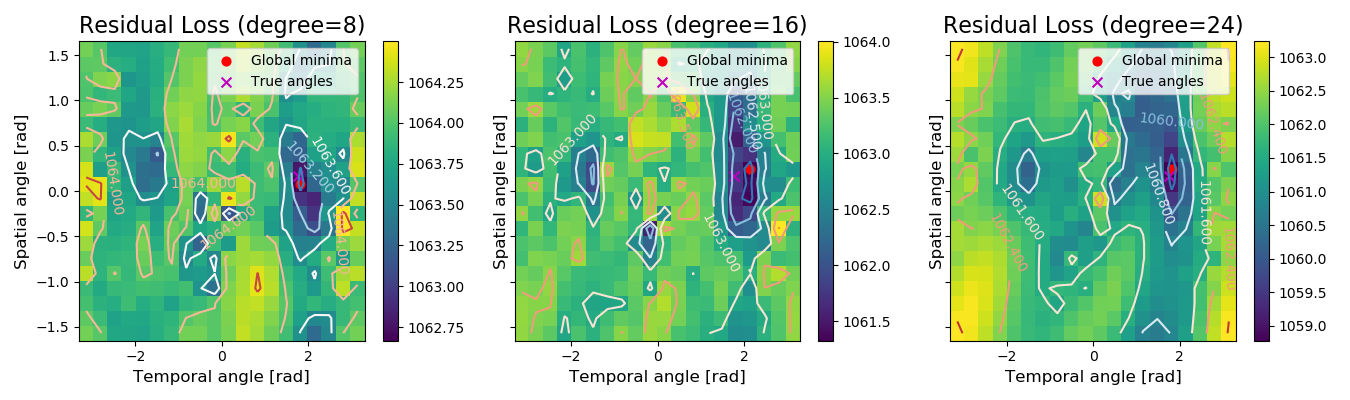

In [193]:
load_path = '../../opening_angles_modes/residuals.spatial_angle0.166_temporal_angle1.77_20x20.nc'
residuals = xr.load_dataarray(load_path)

%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4), sharey=True)
visualization_2d(residuals, degree=8, ax=ax[0])
visualization_2d(residuals, degree=16, ax=ax[1])
visualization_2d(residuals, degree=24, ax=ax[2])
plt.tight_layout()

## GRMHD Measurements
---
General Relativistic Magneto Hydro Dynamics (GRMHD) simulation measurements

### Load Movie

In [85]:
grmhd_directory = '../../GRMHD/'
slider = pynoisy.utils.slider_select_file(grmhd_directory, filetype='h5')

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [348]:
grmhd_movie = pynoisy.utils.load_grmhd(slider.result)
grmhd_movie =  grmhd_movie.interp_like(pynoisy.utils.get_grid(nx, ny))

<IPython.core.display.Javascript object>


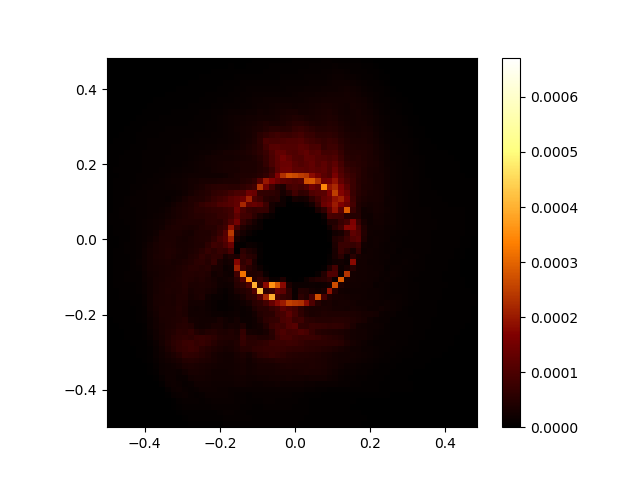

In [349]:
%matplotlib notebook
grmhd_movie.noisy_methods.get_animation()

### Preprocess and Compute Residuals
---
Compute residuals using LOBPCG projection residual from precomputed modes and save as a NetCDF dataset

In [354]:
"""
Preprocessing, use 64 frames of the movie to compute residuals
"""
degree = 24
initial_frame = 200

measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
residuals = compute_residual(files, measurements, degree)

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    directory=directory,
    grmhd=slider.result.split('/')[-1],
    initial_frame=initial_frame,
    nx=nx, ny=ny, nt=nt)

# Save output NetCDF
residuals.to_netcdf(os.path.join(directory, 'residuals.{}.initial_frame{}.{}x{}.nc'.format(
    residuals.grmhd, initial_frame, residuals.spatial_angle.size, residuals.temporal_angle.size)))

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [394]:
"""
A sliding window estimate of parameters
"""
initial_frame = 0
final_frame = 1000
degree = 24 

movie = grmhd_movie[initial_frame:final_frame]
residuals = compute_sliding_residual(files, movie, degree)

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    directory=directory,
    grmhd=slider.result.split('/')[-1],
    initial_frame=initial_frame,
    final_frame=final_frame,
    nx=nx, ny=ny, nt=nt)

# Save output NetCDF
residuals.to_netcdf(os.path.join(directory, 'residuals.{}.initial_frame{}.final_frame{}.{}x{}.nc'.format(
    residuals.grmhd, initial_frame, final_frame, residuals.spatial_angle.size, residuals.temporal_angle.size)))

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Load & Visualize Residuals
---

Load and visualize precomputed residuals

In [307]:
"""
Generate GRF sample from infered opening angles
"""
initial_frame = 200
residual_path = '../../opening_angles_modes/residuals.Ma+0.5_inc10.h5.initial_frame{}.20x20.nc'.format(initial_frame)
residuals = xr.load_dataarray(residual_path)
measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
grf = generate_grf_from_residuals(residuals, seed=1709)

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


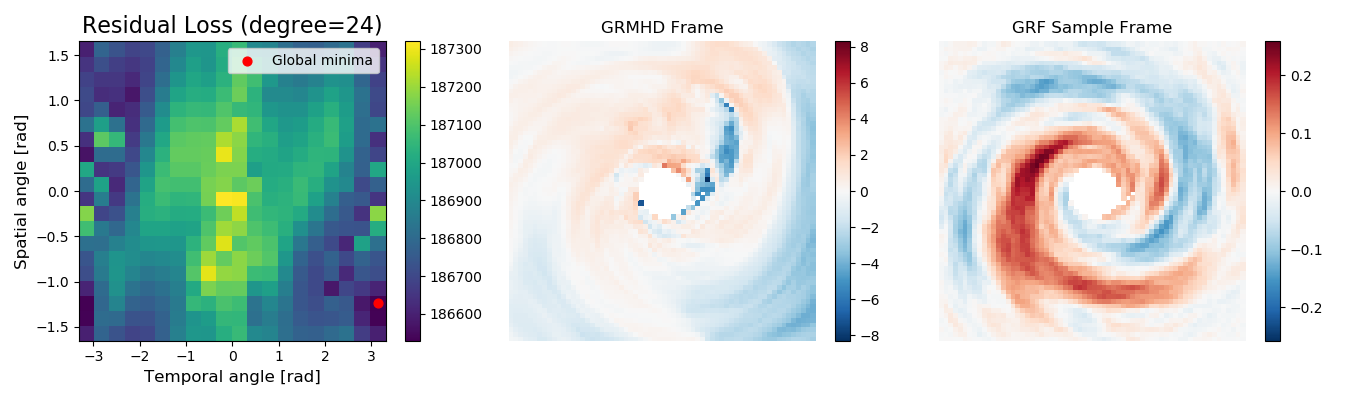

In [308]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4))
visualization_2d(residuals, degree=24, ax=ax[0])
measurements.isel(t=0).plot(ax=ax[1])
ax[1].set_title('GRMHD Frame')
ax[1].axis('off')

grf.isel(t=0).where(np.abs(measurements.isel(t=0) )> 0).plot(ax=ax[2])
ax[2].axis('off')
ax[2].set_title('GRF Sample Frame')

plt.tight_layout()

In [357]:
"""
Generate GRF sample from infered opening angles
"""
initial_frame = 0
residual_path = '../../opening_angles_modes/residuals.Ma0_inc10.h5.initial_frame{}.20x20.nc'.format(initial_frame)
residuals = xr.load_dataarray(residual_path)
measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
grf = generate_grf_from_residuals(residuals, seed=1709)

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


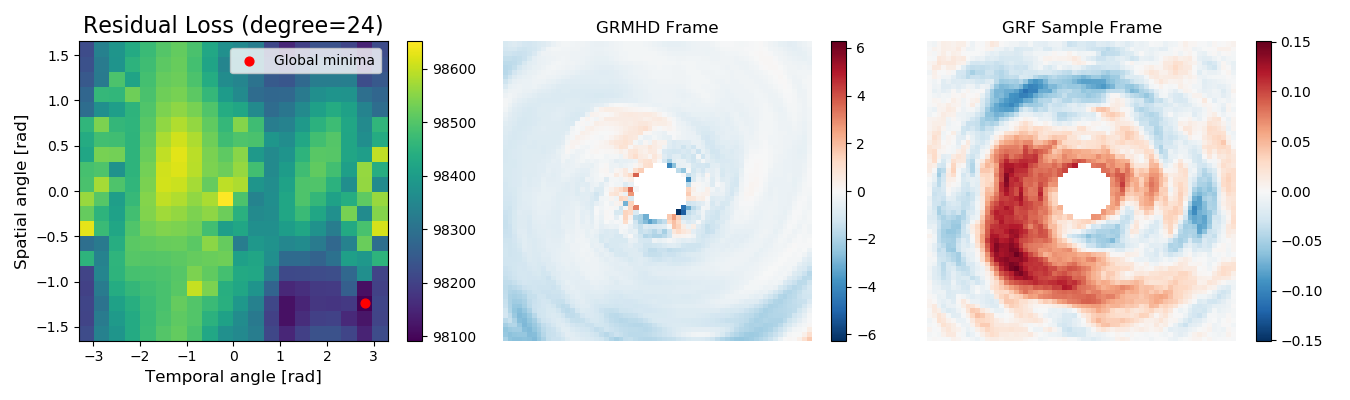

In [358]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4))
visualization_2d(residuals, degree=24, ax=ax[0])
measurements.isel(t=0).plot(ax=ax[1])
ax[1].set_title('GRMHD Frame')
ax[1].axis('off')

grf.isel(t=0).where(np.abs(measurements.isel(t=0) )> 0).plot(ax=ax[2])
ax[2].axis('off')
ax[2].set_title('GRF Sample Frame')

plt.tight_layout()

#### Sliding window analysis

In [309]:
"""
Sliding window analysis
"""
residual_path = '../../opening_angles_modes/residuals.Ma+0.5_inc10.h5.initial_frame0.final_frame1000.20x20.nc'
residuals = xr.load_dataarray(residual_path)

<IPython.core.display.Javascript object>


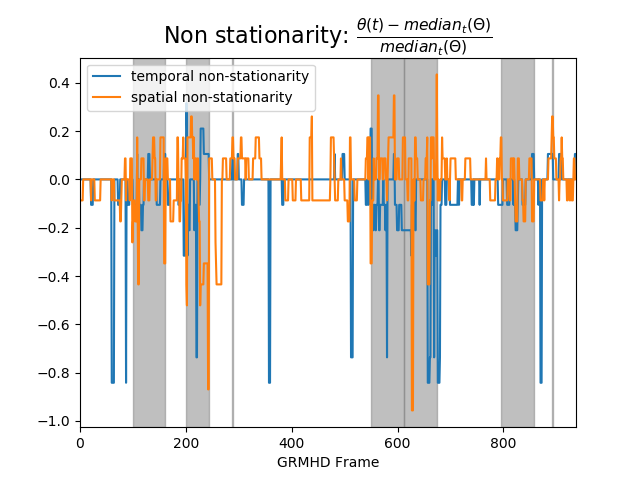

In [310]:
deviation_threshold = 0.3

minimum = residuals[residuals.argmin(dim=['temporal_angle', 'spatial_angle'])]

temporal_angle = np.mod(minimum.temporal_angle + 2*np.pi, 2*np.pi)
spatial_angle = np.mod(minimum.spatial_angle + np.pi, np.pi)

%matplotlib notebook
temporal_nonstationarity = (temporal_angle - temporal_angle.median('initial_frame')) / temporal_angle.median('initial_frame')
temporal_nonstationarity.plot(label='temporal non-stationarity')

spatial_nonstationarity = (spatial_angle - spatial_angle.median('initial_frame')) / spatial_angle.median('initial_frame')
spatial_nonstationarity.plot(label='spatial non-stationarity')

deviations = minimum.where(np.bitwise_and(
    np.abs(temporal_angle - temporal_angle.median('initial_frame')) > deviation_threshold,
    np.abs(spatial_angle - spatial_angle.median('initial_frame')) > deviation_threshold), drop=True)

initial_frames = deviations.initial_frame

# Highlighy regions of non-stationarity
while initial_frames.any():
    region = initial_frames.where(initial_frames < initial_frames[0]+64, drop=True)
    plt.axvspan(region[0], region[-1], color='gray', alpha=0.5) 
    initial_frames = initial_frames.where(initial_frames > region[-1], drop=True)
    
highlight_frame = 205
plt.axvline()
plt.title(r'Non stationarity: $\frac{\theta(t) - median_t(\Theta)}{median_t(\Theta)}$', fontsize=16)
plt.xlim([0, residuals.initial_frame.size])
plt.ylabel(None)
plt.xlabel('GRMHD Frame')
plt.legend()

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


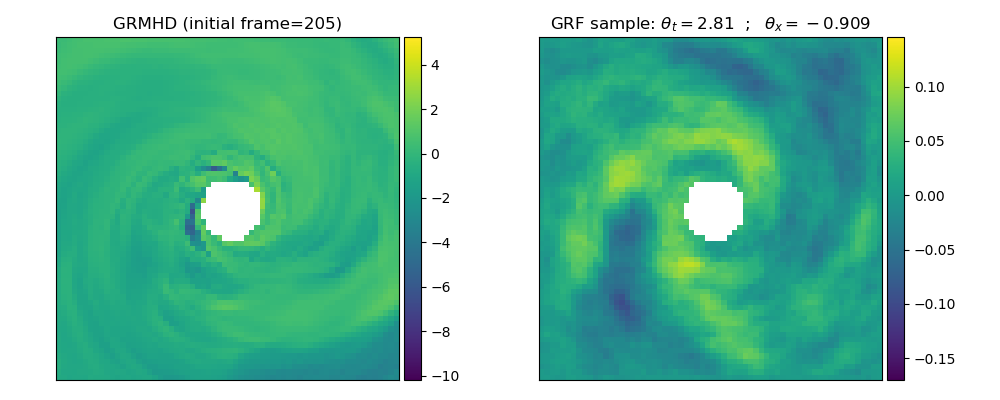

In [335]:
initial_frame = 205

estimated_angles = minimum.sel(initial_frame=initial_frame)
measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
grf = generate_grf_from_residuals(residuals.sel(initial_frame=initial_frame), seed=1709)

%matplotlib notebook
fig, axes = plt.subplots(1,2, figsize=(10,4))
animation = pynoisy.utils.multiple_animations(
    [measurements, grf.where(np.abs(measurements) > 0)], axes.ravel(), cmaps='viridis', 
    titles=['GRMHD (initial frame={})'.format(initial_frame), 
            r'GRF sample: $\theta_t = {:1.3}~~;~~\theta_x = {:1.3}$'.format(grf.temporal_angle, grf.spatial_angle)])

In [ ]:
output_path = '../../opening_angles_modes/Ma+0.5_inc10.h5.initial_frame{}.seed{}.comparison.gif'.format(
    initial_frame, grf.seed)
animation.save(output_path, writer='imagemagick')

In [ ]:
"""
Median GRF
"""
advection = pynoisy.advection.general_xy(nx, ny, opening_angle=float(temporal_angle.median('initial_frame')))
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=float(spatial_angle.median('initial_frame')))
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=1709)
median_grf = solver.run(num_frames=nt, n_jobs=4, verbose=False)

<IPython.core.display.Javascript object>


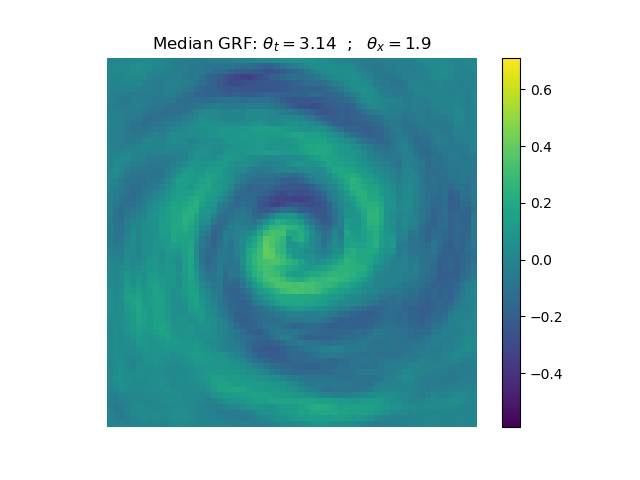

(-0.5, 0.484375, -0.5, 0.484375)

In [344]:
%matplotlib notebook
animation = median_grf.noisy_methods.get_animation(cmap='viridis')
plt.title(r'Median GRF: $\theta_t = {:1.3}~~;~~\theta_x = {:1.3}$'.format
          (advection.opening_angle, diffusion.opening_angle))
plt.axis('off')

In [345]:
output_path = '../../opening_angles_modes/Ma+0.5_inc10.h5.initial_frame{}.seed{}.median_grf.gif'.format(
    initial_frame, grf.seed)
animation.save(output_path, writer='imagemagick')